**lets start with importing the necessary libraries.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor                                                #importing necessary libraries
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
df=pd.read_csv("../input/akshay1/train_cab.csv")
test1=pd.read_csv("../input/akshay2/test.csv")

In [3]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
df.shape

(16067, 7)

In [5]:
df.isnull().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

**there are 80 null values in the dataset. as they are less compared to the size of the dataset, we will remove the observations.**

In [6]:
df=df.dropna()

In [7]:
df.passenger_count.value_counts()

1.00       11243
2.00        2319
5.00        1044
3.00         675
4.00         328
6.00         301
0.00          57
43.00          2
53.00          2
536.00         1
535.00         1
5345.00        1
35.00          1
5334.00        1
554.00         1
537.00         1
0.12           1
1.30           1
531.20         1
345.00         1
456.00         1
557.00         1
354.00         1
58.00          1
236.00         1
87.00          1
Name: passenger_count, dtype: int64

**there are passenger counts which are more than 10. as it is impossible we will remove these observations.**

In [8]:
df=df.loc[(df['passenger_count'] <= 10) & (df['passenger_count'] != 1.30) & (df['passenger_count'] != 0.12)]
test1=test1.loc[(test1['passenger_count'] <= 10) & (test1['passenger_count'] != 1.30) & (test1['passenger_count'] != 0.12)]

In [10]:
df.fare_amount.replace({"430-":"430"},inplace=True)

In [11]:
df["fare_amount"]=df["fare_amount"].astype(float)


In [12]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15967.000000,15967.000000,15967.000000,15967.000000,15967.000000,15967.000000
mean,15.064879,-72.471813,39.919695,-72.471367,39.902773,1.643640
std,431.482857,10.548632,6.818416,10.545282,6.173864,1.267303
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992149,40.734935,-73.991182,40.734708,1.000000
50%,8.500000,-73.981693,40.752607,-73.980167,40.753574,1.000000
75%,12.500000,-73.966819,40.767381,-73.963643,40.768027,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,6.000000


**there are some cases where fare amount is negative. we will remove them.**

In [13]:
df=df.loc[df['fare_amount'] >= 0]

In [14]:
df["pickup_latitude"].value_counts()

0.000000     311
41.366138     10
40.759397      5
40.755815      4
40.747282      4
            ... 
40.729134      1
40.718160      1
40.760676      1
40.724697      1
40.752322      1
Name: pickup_latitude, Length: 14158, dtype: int64

**The dataset is of cab rides in new york. we will remove all the observations which are outside of new york as they are outliers for our dataset.**

In [15]:
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    
    test1= test1[(-76 <= test1['pickup_longitude']) & (test1['pickup_longitude'] <= -72)]
    test1 = test1[(-76 <= test1['dropoff_longitude']) & (test1['dropoff_longitude'] <= -72)]
    test1 = test1[(38 <= test1['pickup_latitude']) & (test1['pickup_latitude'] <= 42)]
    test1 = test1[(38 <= test1['dropoff_latitude']) & (test1['dropoff_latitude'] <= 42)]
    
    test1 = test1[(test1['dropoff_longitude'] != test1['pickup_longitude'])]
    test1 = test1[(test1['dropoff_latitude'] != test1['pickup_latitude'])]
    
    

In [16]:
df.shape

(15470, 7)

**to make things easier we will create functions to tell whether ride happened at late night or night. we will extract day,month,year,hour,weekday from datetime column to make things easier for us.**

In [17]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df



def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


In [18]:
df=df[df["pickup_datetime"]!='43']

In [19]:
df = add_time_features(df)

df=add_coordinate_features(df)

test1 = add_time_features(test1)

test1=add_coordinate_features(test1)






test1.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,night,late_night,latdiff,londiff
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,0,0,0.019970,0.008110
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,0,0,-0.019817,0.012024
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0,0,0.005121,-0.002870
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,0,1,0.016172,0.009288
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,0,1,0.045348,0.022519


**there are some rides where fare prices are above 250 dollars. as it is practically impossible we will omit them.**

In [20]:
df=df[df["fare_amount"] <= 250]

In [21]:
test1.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,night,late_night,latdiff,londiff
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,0,0,0.019970,0.008110
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,0,0,-0.019817,0.012024
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0,0,0.005121,-0.002870
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,0,1,0.016172,0.009288
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,0,1,0.045348,0.022519


In [22]:
df.to_csv('taxi_train.csv',index=False)
test1.to_csv('taxi_test.csv',index=False)


In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,night,late_night,latdiff,londiff
count,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000,15464.000000
mean,11.304898,-73.975186,40.750761,-73.974204,40.751261,1.646146,2011.736291,6.270758,15.666839,13.510541,3.035760,0.201371,0.370991,-0.000500,-0.000982
std,9.460218,0.038091,0.036312,0.035727,0.038084,1.269171,1.868305,3.449072,8.686576,6.505641,1.969784,0.401038,0.483086,0.038835,0.044909
min,0.000000,-74.438233,39.603178,-74.227047,39.604972,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.168673,-0.836968
25%,6.000000,-73.992389,40.736616,-73.991372,40.736370,1.000000,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000,0.000000,-0.014603,-0.013978
50%,8.500000,-73.982079,40.753391,-73.980575,40.754262,1.000000,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000,0.000000,-0.000126,-0.001260
75%,12.500000,-73.968188,40.767805,-73.965549,40.768338,2.000000,2013.000000,9.000000,23.000000,19.000000,5.000000,0.000000,1.000000,0.014234,0.011884
max,165.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.165157,0.863547


# EXPLORATORY DATA ANALYSIS

**we will create a function which will tell us about the distance travelled in miles.**

In [24]:
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [25]:
df['trip_distance']=df.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test1['trip_distance']=test1.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

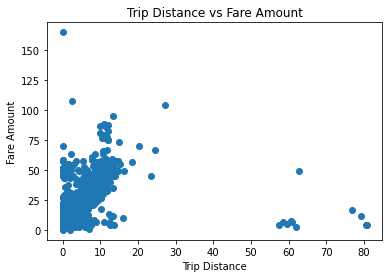

In [26]:
plt.scatter(x=df['trip_distance'],y=df['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

**there seems to be a linear relation between the distance travelled and the fare amount. however trips > 50 miles have low prices and constant rates. maybe because normally long trips from airports have fixed prices.**

In [27]:
JFK={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
JFK_center=[40.6437,-73.7900]
# Get all pickups to JFK
JFK_data=df.loc[(df.pickup_latitude>=JFK['min_lat']) & (df.pickup_latitude<=JFK['max_lat'])&(df.pickup_longitude>=JFK['min_lng']) & (df.pickup_longitude<=JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=df.loc[(df.dropoff_latitude>=JFK['min_lat']) & (df.dropoff_latitude<=JFK['max_lat'])&(df.dropoff_longitude>=JFK['min_lng']) & (df.dropoff_longitude<=JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])

Number of Trips with Pickups from JFK 239
Number of Trips with Dropoffs to JFK 114


Text(0.5, 1.0, 'Fare Amount Distribution')

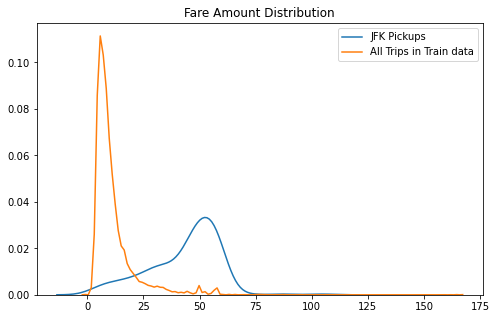

In [28]:
plt.figure(figsize=(8,5))
sns.kdeplot(JFK_data['fare_amount'].values,label='JFK Pickups')
#sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(df['fare_amount'].values,label='All Trips in Train data')
plt.title("Fare Amount Distribution")

In [29]:
print("mean fare price from JFK airport = ",JFK_data['fare_amount'].mean())
print("mean fare price from other areas = ",df['fare_amount'].mean())

mean fare price from JFK airport =  43.30824267782427
mean fare price from other areas =  11.304898473874802


In [30]:
del JFK_data
del JFK
del JFK_dropoff

In [31]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        

**we will create a function which will tell us whether the pickup or drop happened at one of the 3 airports in new york.**








In [32]:
df['is_pickup_JFK']=df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
df['is_dropoff_JFK']=df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
df['is_pickup_EWR']=df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
df['is_dropoff_EWR']=df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
df['is_pickup_la_guardia']=df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
df['is_dropoff_la_guardia']=df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

test1['is_pickup_JFK']=test1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test1['is_dropoff_JFK']=test1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
test1['is_pickup_EWR']=test1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test1['is_dropoff_EWR']=test1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test1['is_pickup_la_guardia']=test1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test1['is_dropoff_la_guardia']=test1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)




In [33]:
df.shape

(15464, 22)

**AS we saw above. prices are low and almost constant for trips > 50 miles. maybe because long trips from airports have fixed prices.**

**new york has 5 major boroughs. we will create a function and try and find the mean fare price at each of the boroughs.**

In [35]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}

In [36]:
for i in nyc_boroughs:
    print("mean ride price in "+i +" :",df.loc[(df["dropoff_latitude"] >= nyc_boroughs[i]["min_lat"]) & (df["dropoff_latitude"] <= nyc_boroughs[i]["max_lat"])&(df["dropoff_longitude"] >= nyc_boroughs[i]["min_lng"])& (df["dropoff_longitude"] <= nyc_boroughs[i]["max_lng"]) ]["fare_amount"].mean())

mean ride price in manhattan : 10.177208424807949
mean ride price in queens : 14.693250245982323
mean ride price in brooklyn : 11.69662754491019
mean ride price in bronx : 24.933968253968256
mean ride price in staten_island : 27.099999999999998


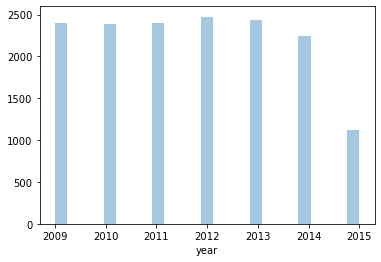

In [37]:
sns.distplot(df["year"],norm_hist=False,kde=False)

from 2009 the demand has been increasing slightly . however in 2015 the demand has gone down drastically compared to other years. the other reason might be that the amount of data provided for this year is less.

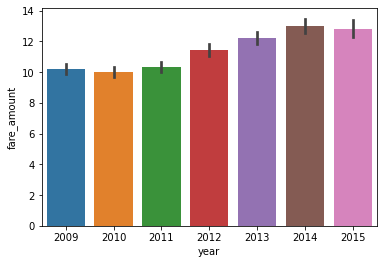

In [38]:
sns.barplot(x="year",y="fare_amount",data=df)

**the average fare amount went down in the year 2010. after that the prices have been rising every year till 2014. in 2015 the prices went down a bit again maybe because the demand decreased or maybe the data provided for this year is less.**

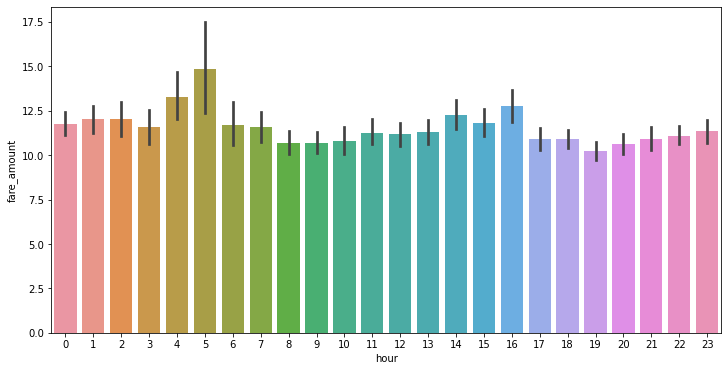

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(x="hour",y="fare_amount",data=df)


**it can be seen that the fare amount is high at late night especially after 10pm. the highest fare amount occurs at 5 am. in other words if the passenger is travelling late night he/she can expect to be charged a higher fare price.**

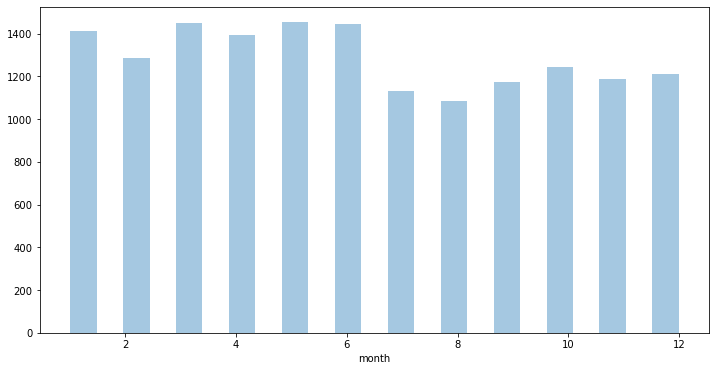

In [40]:
plt.figure(figsize=(12,6))
sns.distplot(df["month"],norm_hist=False,kde=False)


the cab demand seems to go down in the second half of the year after june.march-june seem the peak season for cab demands.

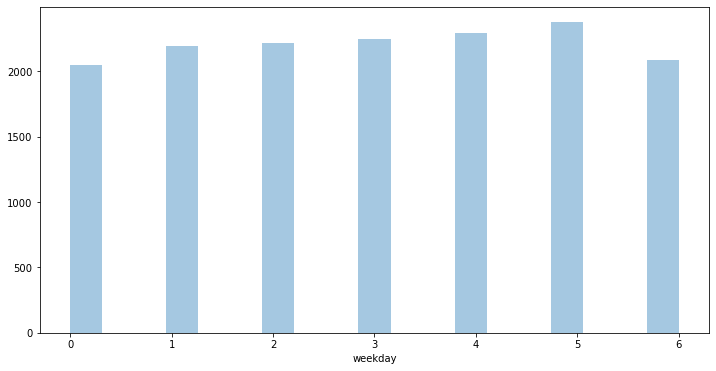

In [41]:
plt.figure(figsize=(12,6))
sns.distplot(df["weekday"],norm_hist=False,kde=False)

the demand for cabs are highest on staurdays.

In [161]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,night,late_night,trip_distance,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia
0,4.5,0.456568,0.634241,0.353724,0.628735,1.0,2009,6,15,17,0,1,0,0.640487,0,0,0,0,0,0
1,16.9,0.324548,0.628559,0.227392,0.668326,1.0,2010,1,5,16,1,1,0,5.250670,0,0,0,0,0,0
2,5.7,0.350155,0.656902,0.216404,0.650473,2.0,2011,8,18,0,3,0,1,0.863411,0,0,0,0,0,0
3,7.7,0.346778,0.640948,0.216105,0.654748,1.0,2012,4,21,4,5,0,1,1.739386,0,0,0,0,0,0
4,5.3,0.361411,0.660724,0.248145,0.669324,1.0,2010,3,9,7,1,0,0,1.242218,0,0,0,0,0,0


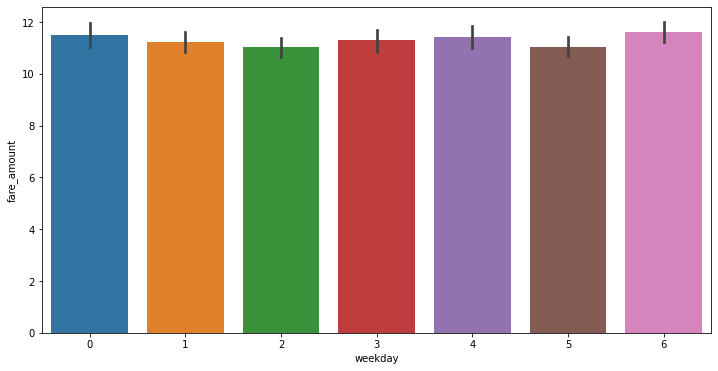

In [42]:
plt.figure(figsize=(12,6))
sns.barplot(x="weekday",y="fare_amount",data=df)

theres not much difference in fare prices based day of the week.

lets find the average price if the pickup is from an airport.

In [43]:
print("The mean price of normal pickup :", df.loc[(df["is_pickup_JFK"] ==0) & (df["is_pickup_EWR"] ==0) & (df["is_pickup_la_guardia"] ==0)]["fare_amount"].mean(),"$")
print("The mean price of airport pickup :", df.loc[(df["is_pickup_JFK"] ==1) | (df["is_pickup_EWR"] ==1) | (df["is_pickup_la_guardia"] ==1)]["fare_amount"].mean(),"$")


The mean price of normal pickup : 10.37905832606218 $
The mean price of airport pickup : 35.7192212389381 $


As we can see the average ride price for pickup from an airport is almost 36 dollars whereas for a normal ride it is 11 dollars.

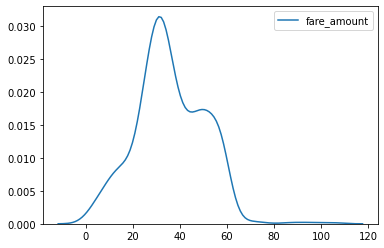

In [44]:
sns.kdeplot(df.loc[(df["is_pickup_JFK"] ==1) | (df["is_pickup_EWR"] ==1) | (df["is_pickup_la_guardia"] ==1)]["fare_amount"])

In [45]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff',
       'londiff', 'trip_distance', 'is_pickup_JFK', 'is_dropoff_JFK',
       'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_la_guardia',
       'is_dropoff_la_guardia'],
      dtype='object')

In [46]:
df["is_dropoff_EWR"].value_counts()

0    15441
1       23
Name: is_dropoff_EWR, dtype: int64

In [47]:
df.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,late_night,latdiff,londiff,trip_distance,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia
fare_amount,1.000000,0.394388,-0.146682,0.337039,-0.115816,0.008060,0.115183,0.041710,-0.007012,-0.030389,...,0.011665,-0.023577,0.066389,0.688759,0.423866,0.334324,NaN,0.227651,0.292424,0.245219
pickup_longitude,0.394388,1.000000,0.099377,0.261075,0.055090,-0.002282,0.006635,0.005464,0.003438,0.020015,...,-0.045591,0.038897,0.640501,0.469472,0.626855,0.042474,NaN,-0.034586,0.406558,0.015548
pickup_latitude,-0.146682,0.099377,1.000000,0.048681,0.455873,-0.001331,-0.010555,0.005919,-0.010218,0.024229,...,-0.099689,0.487990,0.045564,-0.142213,-0.363296,-0.017117,NaN,0.010672,0.086301,0.003111
dropoff_longitude,0.337039,0.261075,0.048681,1.000000,0.173178,-0.005742,0.005583,0.017733,0.006203,-0.051008,...,0.035816,-0.124313,-0.574104,0.356563,0.129632,0.453793,NaN,-0.221552,0.073408,0.341692
dropoff_latitude,-0.115816,0.055090,0.455873,0.173178,1.000000,-0.001641,0.006283,0.012163,-0.001683,0.013448,...,-0.060757,-0.554413,-0.091044,-0.146305,-0.059049,-0.236327,NaN,-0.059707,-0.021861,0.063329
passenger_count,0.008060,-0.002282,-0.001331,-0.005742,-0.001641,1.000000,0.002536,0.009833,0.002123,0.017072,...,0.014140,0.000365,0.002632,-0.002514,0.000236,0.006159,NaN,-0.005105,0.026374,-0.005380
year,0.115183,0.006635,-0.010555,0.005583,0.006283,0.002536,1.000000,-0.116003,-0.026103,-0.004102,...,0.002429,-0.016031,0.001186,0.000309,0.017685,0.008927,NaN,-0.011618,0.014209,-0.003827
month,0.041710,0.005464,0.005919,0.017733,0.012163,0.009833,-0.116003,1.000000,-0.016459,-0.003400,...,0.014193,-0.006394,-0.009472,0.012454,0.006884,0.013619,NaN,0.018378,0.011190,0.017536
day,-0.007012,0.003438,-0.010218,0.006203,-0.001683,0.002123,-0.026103,-0.016459,1.000000,0.000299,...,-0.002414,-0.007904,-0.002018,-0.004002,0.005952,0.005916,NaN,0.005151,-0.009659,0.008677
hour,-0.030389,0.020015,0.024229,-0.051008,0.013448,0.017072,-0.004102,-0.003400,0.000299,1.000000,...,0.032945,0.009467,0.057556,-0.029339,0.012408,-0.021172,NaN,-0.007672,0.033322,-0.036084


In [48]:
df["is_pickup_EWR"].value_counts()

0    15464
Name: is_pickup_EWR, dtype: int64

In [49]:
df.drop(columns=["latdiff","londiff"],inplace=True)

In [50]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'trip_distance', 'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR',
       'is_dropoff_EWR', 'is_pickup_la_guardia', 'is_dropoff_la_guardia'],
      dtype='object')

In [51]:
df["night"]=pd.Categorical(df["night"])
df["late_night"]=pd.Categorical(df["late_night"])
df["weekday"]=pd.Categorical(df["weekday"])
df["month"]=pd.Categorical(df["month"])
df["day"]=pd.Categorical(df["day"])
df["is_pickup_JFK"]=pd.Categorical(df["is_pickup_JFK"])
df["is_dropoff_JFK"]=pd.Categorical(df["is_dropoff_JFK"])
df["is_pickup_EWR"]=pd.Categorical(df["is_pickup_EWR"])
df["is_dropoff_EWR"]=pd.Categorical(df["is_dropoff_EWR"])
df["is_pickup_la_guardia"]=pd.Categorical(df["is_pickup_la_guardia"])
df["is_dropoff_la_guardia"]=pd.Categorical(df["is_dropoff_la_guardia"])

test1["night"]=pd.Categorical(test1["night"])
test1["late_night"]=pd.Categorical(test1["late_night"])
test1["weekday"]=pd.Categorical(test1["weekday"])
test1["month"]=pd.Categorical(test1["month"])
test1["day"]=pd.Categorical(test1["day"])
test1["is_pickup_JFK"]=pd.Categorical(test1["is_pickup_JFK"])
test1["is_dropoff_JFK"]=pd.Categorical(test1["is_dropoff_JFK"])
test1["is_pickup_EWR"]=pd.Categorical(test1["is_pickup_EWR"])
test1["is_dropoff_EWR"]=pd.Categorical(test1["is_dropoff_EWR"])
test1["is_pickup_la_guardia"]=pd.Categorical(test1["is_pickup_la_guardia"])
test1["is_dropoff_la_guardia"]=pd.Categorical(test1["is_dropoff_la_guardia"])

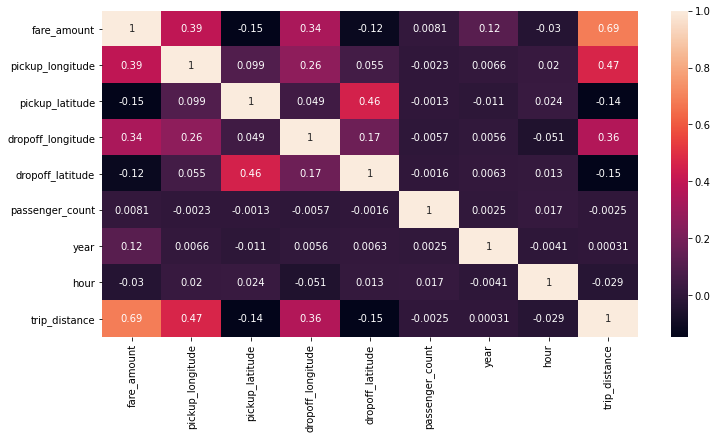

In [123]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

In [124]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'trip_distance', 'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR',
       'is_dropoff_EWR', 'is_pickup_la_guardia', 'is_dropoff_la_guardia'],
      dtype='object')

In [125]:
df["pickup_longitude"]=(df["pickup_longitude"]-df["pickup_longitude"].min())/(df["pickup_longitude"].max()-df["pickup_longitude"].min())
df["pickup_latitude"]=(df["pickup_latitude"]-df["pickup_latitude"].min())/(df["pickup_latitude"].max()-df["pickup_latitude"].min())
df["dropoff_longitude"]=(df["dropoff_longitude"]-df["dropoff_longitude"].min())/(df["dropoff_longitude"].max()-df["dropoff_longitude"].min())
df["dropoff_latitude"]=(df["dropoff_latitude"]-df["dropoff_latitude"].min())/(df["dropoff_latitude"].max()-df["dropoff_latitude"].min())

test1["pickup_longitude"]=(test1["pickup_longitude"]-test1["pickup_longitude"].min())/(test1["pickup_longitude"].max()-test1["pickup_longitude"].min())
test1["pickup_latitude"]=(test1["pickup_latitude"]-test1["pickup_latitude"].min())/(test1["pickup_latitude"].max()-test1["pickup_latitude"].min())
test1["dropoff_longitude"]=(test1["dropoff_longitude"]-test1["dropoff_longitude"].min())/(test1["dropoff_longitude"].max()-test1["dropoff_longitude"].min())
test1["dropoff_latitude"]=(test1["dropoff_latitude"]-test1["dropoff_latitude"].min())/(test1["dropoff_latitude"].max()-test1["dropoff_latitude"].min())


In [126]:
train_attributes=df[['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'trip_distance', 'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR',
       'is_dropoff_EWR', 'is_pickup_la_guardia', 'is_dropoff_la_guardia']]
cat_attributes=["month","weekday"]

train_attributes_test1=test1[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'trip_distance', 'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR',
       'is_dropoff_EWR', 'is_pickup_la_guardia', 'is_dropoff_la_guardia']]

In [127]:
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes,drop_first=True)
print("shape of data frame is" , train_encoded_attributes.shape )
train_encoded_attributes.columns





shape of data frame is (15464, 35)


Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'late_night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [128]:
test_encoded_attributes=pd.get_dummies(train_attributes_test1,columns=cat_attributes,drop_first=True)

# Feature engineering**

In [129]:
from sklearn import linear_model

In [130]:
lrmodel=linear_model.LinearRegression(normalize=False)
lrmodel

LinearRegression()

In [131]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(lrmodel,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'late_night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [132]:
score.mean()

0.6022669771218124

In [133]:
from sklearn.tree import DecisionTreeRegressor

In [134]:
dtreg=DecisionTreeRegressor()

In [135]:
score1=cross_val_score(dtreg,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'late_night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [136]:
score1.mean()

0.6462835922178906

In [137]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200)

In [66]:
score2=cross_val_score(rf,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'late_night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [67]:
score2.mean()

0.8080974305735603

lets try hyperparameter tuning and feature scaling to try and increase the model's accuracy.we will use anova test and gridsearch CV for this.

In [138]:
from scipy.stats import f_oneway 

In [139]:
f_oneway(df[df.night==1].fare_amount,df[df.night==0].fare_amount)

F_onewayResult(statistic=2.5541368174298373, pvalue=0.11002631494425076)

In [140]:
f_oneway(df[df.late_night==1].fare_amount,df[df.late_night==0].fare_amount)

F_onewayResult(statistic=2.10414580344076, pvalue=0.14692064160126322)

In [141]:
f_oneway(df[df.weekday==0].fare_amount,df[df.weekday==1].fare_amount,df[df.weekday==2].fare_amount,df[df.weekday==3].fare_amount,df[df.weekday==4].fare_amount,df[df.weekday==5].fare_amount,df[df.weekday==6].fare_amount)

F_onewayResult(statistic=1.2316089257882177, pvalue=0.286378340331119)

weekday variable dosent seem to have much impact on the fare amount. the p value shows that it is not a significant parameter to impact the fare amount.

In [142]:
f_oneway(df[df.is_pickup_JFK==1].fare_amount,df[df.is_pickup_JFK==0].fare_amount)

F_onewayResult(statistic=3386.3372316381283, pvalue=0.0)

In [143]:
 f_oneway(df[df.is_dropoff_EWR==1].fare_amount,df[df.is_dropoff_EWR==0].fare_amount)

F_onewayResult(statistic=845.1137700203254, pvalue=5.957119786536598e-181)

In [74]:
f_oneway(df[df.is_pickup_la_guardia==1].fare_amount,df[df.is_pickup_la_guardia==0].fare_amount)

F_onewayResult(statistic=1445.813908075614, pvalue=1.6207916810445326e-302)

In [75]:
f_oneway(df[df.is_dropoff_la_guardia==1].fare_amount,df[df.is_dropoff_la_guardia==0].fare_amount)

F_onewayResult(statistic=989.2542877369631, pvalue=1.5689422306435305e-210)

According to the above results we will omit weekday and late_night variables as they are not having much impact on the accuracy.

In [155]:
import statsmodels.api as sm
from pandas import DataFrame,Series
from scipy import stats

In [144]:
score=cross_val_score(lrmodel,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [145]:
score.mean()

0.6033193405325546

In [148]:
score1=cross_val_score(dtreg,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [149]:
score1.mean()

0.6393318371268981

In [150]:
from sklearn.model_selection import GridSearchCV

In [151]:
dtreg1= GridSearchCV(DecisionTreeRegressor(),{'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]},cv=5,return_train_score=False
    
)

In [152]:
dtreg1.fit(train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].values,train_encoded_attributes["fare_amount"].values)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18]})

In [153]:
res=pd.DataFrame(dtreg1.cv_results_)

In [154]:
res.nlargest(10,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.092874,0.000614,0.007744,0.000069,6,{'max_depth': 6},0.665312,0.833574,0.856947,0.755076,0.760387,0.774260,0.067506,1
3,0.087019,0.003604,0.007724,0.000104,5,{'max_depth': 5},0.661838,0.828381,0.851425,0.750798,0.763798,0.771248,0.066538,2
5,0.101345,0.000646,0.007711,0.000064,7,{'max_depth': 7},0.665415,0.791323,0.811846,0.763628,0.758154,0.758073,0.050226,3
2,0.081665,0.002616,0.008425,0.000392,4,{'max_depth': 4},0.667287,0.801187,0.832587,0.724151,0.758050,0.756652,0.057955,4
6,0.111464,0.001967,0.007811,0.000163,8,{'max_depth': 8},0.653927,0.717276,0.818756,0.727175,0.745938,0.732614,0.053018,5
1,0.069770,0.002931,0.008246,0.000356,3,{'max_depth': 3},0.642217,0.763849,0.800956,0.673259,0.723769,0.720810,0.057832,6
7,0.118926,0.000301,0.007857,0.000094,9,{'max_depth': 9},0.635780,0.691650,0.800883,0.733751,0.716957,0.715804,0.053943,7
0,0.054184,0.000780,0.007619,0.000129,2,{'max_depth': 2},0.605221,0.746642,0.777850,0.718887,0.697161,0.709152,0.058592,8
8,0.137513,0.007538,0.008339,0.000419,10,{'max_depth': 10},0.632358,0.692322,0.772074,0.717183,0.713949,0.705577,0.045085,9
10,0.143665,0.001346,0.007937,0.000125,12,{'max_depth': 12},0.614698,0.744347,0.757816,0.689173,0.693346,0.699876,0.050492,10


As we can see when we reduced the max depth parameter to 6 we increased the accuracy from 64% to 77%. this shows that before the tuning the decision tree was overfit.

In [85]:
rf1= GridSearchCV(RandomForestRegressor(),{'n_estimators':[100,150,200,250,300],'max_features':['auto','sqrt','log2'],'min_samples_leaf':[1,2,3]},cv=5,return_train_score=False
    
)

In [86]:
rf1.fit(train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].values,train_encoded_attributes["fare_amount"].values)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [87]:
res1=pd.DataFrame(rf1.cv_results_)

In [88]:
score2=cross_val_score(rf,train_encoded_attributes[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].values,train_encoded_attributes["fare_amount"].values,cv=5)

In [89]:
score2.mean()

0.8088912666081495

In [90]:
res1.nlargest(10,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,28.124371,0.349035,0.215992,0.001848,auto,3,300,"{'max_features': 'auto', 'min_samples_leaf': 3...",0.703160,0.846172,0.876332,0.849802,0.809233,0.816940,0.060774,1
12,18.796751,0.310681,0.153926,0.018046,auto,3,200,"{'max_features': 'auto', 'min_samples_leaf': 3...",0.702828,0.845703,0.876730,0.848322,0.808866,0.816490,0.060783,2
13,23.452913,0.257108,0.181353,0.002990,auto,3,250,"{'max_features': 'auto', 'min_samples_leaf': 3...",0.703356,0.846575,0.876438,0.847023,0.808112,0.816301,0.060499,3
10,9.515836,0.259021,0.079895,0.005992,auto,3,100,"{'max_features': 'auto', 'min_samples_leaf': 3...",0.702944,0.846853,0.876915,0.847300,0.806263,0.816055,0.060858,4
11,14.132840,0.228067,0.111555,0.001642,auto,3,150,"{'max_features': 'auto', 'min_samples_leaf': 3...",0.703125,0.845028,0.877821,0.846097,0.806675,0.815749,0.060659,5
6,15.329561,0.277910,0.128302,0.003581,auto,2,150,"{'max_features': 'auto', 'min_samples_leaf': 2...",0.698605,0.845209,0.878665,0.847776,0.806268,0.815305,0.062712,6
9,30.545469,0.499468,0.248437,0.003471,auto,2,300,"{'max_features': 'auto', 'min_samples_leaf': 2...",0.699698,0.845025,0.877655,0.847501,0.805188,0.815014,0.062088,7
8,25.394254,0.307606,0.207695,0.002365,auto,2,250,"{'max_features': 'auto', 'min_samples_leaf': 2...",0.699826,0.845781,0.877456,0.845696,0.806211,0.814994,0.061859,8
7,20.384227,0.163666,0.167058,0.003529,auto,2,200,"{'max_features': 'auto', 'min_samples_leaf': 2...",0.700349,0.845035,0.877354,0.846168,0.805160,0.814813,0.061649,9
24,8.517134,0.081910,0.242862,0.003921,sqrt,2,300,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.708928,0.852389,0.869102,0.838782,0.803848,0.814610,0.057036,10


as we can see after parameter tuning we have increased the accuracy from 80% to almost 82%.

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
train,test = train_test_split(train_encoded_attributes[["fare_amount",
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']],test_size=0.2)

test_encoded_attributes=test_encoded_attributes[[
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'hour', 'night', 'trip_distance', 'is_pickup_JFK',
       'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']]

In [93]:
train.shape

(12371, 26)

In [94]:
y_train=train["fare_amount"]
y_test=test["fare_amount"]

In [95]:
x_train=train.drop(columns="fare_amount")
x_test=test.drop(columns="fare_amount")

In [96]:
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)


In [97]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

In [98]:
lr=linear_model.LinearRegression(normalize=False)
lr

LinearRegression()

In [99]:
lr.fit(x_train.iloc[:,0:25],y_train.iloc[:,0])

LinearRegression()

In [100]:
predictions_lr=lr.predict(x_test.iloc[:,0:25])

In [101]:
predictions_lr

array([ 8.30897838,  9.27554795,  7.85135704, ...,  7.79560236,
        9.43910169, 10.09832875])

In [102]:
lr.score(x_train,y_train)

0.6421877726319991

In [103]:
rmse=sqrt(mean_squared_error(y_test.iloc[:,0].values,predictions_lr))
print("RMSE = " ,rmse)
mae= mean_absolute_error(y_test.iloc[:,0].values,predictions_lr)
print("MAE = ",mae)
mse=mean_squared_error(y_test.iloc[:,0].values,predictions_lr)
print("MSE = " ,mse)

RMSE =  5.735230246490969
MAE =  3.038840691427525
MSE =  32.89286598026485


Text(0.5, 1.0, 'Linear model performance graph')

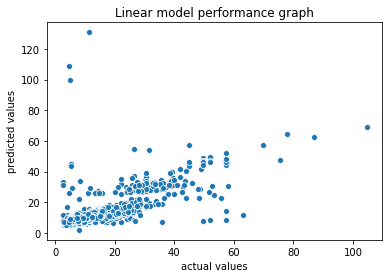

In [104]:
sns.scatterplot(x=y_test.iloc[:,0].values,y=predictions_lr)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("Linear model performance graph")

In [105]:
dt=DecisionTreeRegressor(max_depth=6)
dt

DecisionTreeRegressor(max_depth=6)

In [106]:
dt.fit(x_train.iloc[:,0:25],y_train.iloc[:,0])

DecisionTreeRegressor(max_depth=6)

In [107]:
predictions_dt=dt.predict(x_test.iloc[:,0:25])

In [108]:
predictions_dt

array([7.03761702, 7.03761702, 7.03761702, ..., 7.03761702, 7.03761702,
       7.03761702])

In [109]:
dt.score(x_test,y_test)

0.7824842142023101

In [110]:
rmse=sqrt(mean_squared_error(y_test.iloc[:,0].values,predictions_dt))
print("RMSE = " ,rmse)
mae= mean_absolute_error(y_test.iloc[:,0].values,predictions_dt)
print("MAE = ",mae)
mse=mean_squared_error(y_test.iloc[:,0].values,predictions_dt)
print("MSE = " ,mse)

RMSE =  4.248370183389676
MAE =  2.155142864164832
MSE =  18.048649215114434


Text(0.5, 1.0, 'decision tree performance graph')

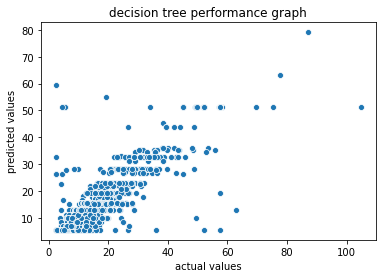

In [111]:
sns.scatterplot(x=y_test.iloc[:,0].values,y=predictions_dt)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("decision tree performance graph")

In [112]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=300, min_samples_leaf=3,max_features='auto')

In [113]:
rf.fit(x_train.iloc[:,0:25],y_train.iloc[:,0])

RandomForestRegressor(min_samples_leaf=3, n_estimators=300)

In [114]:
predictions_rf=rf.predict(x_test.iloc[:,0:25])

In [115]:
predictions_rf

array([7.34557163, 8.61407624, 7.07955701, ..., 6.20812494, 7.85148031,
       9.7640549 ])

In [116]:
rf.score(x_test,y_test)

0.80321680251514

In [117]:
rmse=sqrt(mean_squared_error(y_test.iloc[:,0].values,predictions_rf))
print("RMSE = " ,rmse)
mae= mean_absolute_error(y_test.iloc[:,0].values,predictions_rf)
print("MAE = ",mae)
mse=mean_squared_error(y_test.iloc[:,0].values,predictions_rf)
print("MSE = " ,mse)

RMSE =  4.040833615497487
MAE =  1.9611173121061822
MSE =  16.328336308134492


Text(0.5, 1.0, 'random forests performance graph')

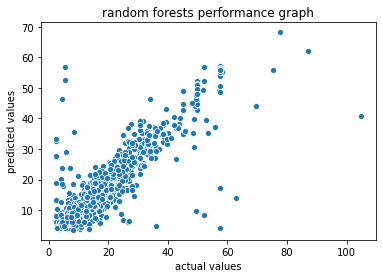

In [118]:
sns.scatterplot(x=y_test.iloc[:,0].values,y=predictions_rf)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("random forests performance graph")

As we can see from the graphs and the error metrics that random forest algorithm is giving the best result. therefore we will select this algorithm for the model.

In [119]:
test_predictions=rf.predict(test_encoded_attributes.iloc[:,0:25])

In [120]:
test_predictions

array([10.96321476, 10.80348509,  5.19936039, ..., 51.00368766,
       23.50204699,  7.22225465])